In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix,
    mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier


In [103]:
# Load data for Ashley
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/665 - Applied Stat II/2025_NBA_Project/nba_playoffdata_combined.csv")
data2025 = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/665 - Applied Stat II/2025_NBA_Project/nba_playoffdata_2025.csv")

In [104]:
print(data.shape)
print(data2025.shape)

(656, 56)
(8, 51)


In [105]:
# Save team name columns
winners = data['Winner'].copy()
losers = data['Loser'].copy()

match = data2025['Match'].copy()

# Create net win column (response var)
def compute_net_wins(row):
    win_diff = row['Winner Games Won'] - row['Loser Games Won']

    if row['Winner Seed'] < row['Loser Seed']:
        return win_diff
    else:  
        return -win_diff

data['Net Wins'] = data.apply(compute_net_wins, axis=1)

# Drop non-feature columns, columns that make 'Net Wins' dependent, and 
data.drop(columns=['Winner', 'Loser', 'Winner Team', 'Loser Team', 
                   'Winner Games Won', 'Loser Games Won'], inplace=True)
data2025.drop(columns = 'Match', inplace=True)

# Create dummy variables for categorical
data = pd.get_dummies(data, drop_first=False)
data2025 = pd.get_dummies(data2025, drop_first=False)

# Aligning feature names in both datasets
missing_cols = set(data.columns) - set(data2025.columns)
for col in missing_cols:
    data2025[col] = False
data2025 = data2025[data.columns]

# Drop baseline Round (Eastern Cof First Round) and non-feature columns
data.drop(columns='Round_Eastern Conf First Round', inplace=True)
data2025.drop(columns = ['Round_Eastern Conf First Round', 'Net Wins'], inplace=True)

# Check data
data.head()

,Year,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,Winner 3P,Winner 3PA,...,Loser TOV,Loser PF,Loser PTS,Net Wins,Round_Eastern Conf Finals,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2024,1,8,2,241.8,43.9,90.2,0.487,16.5,42.5,...,12.7,17.3,110.1,3,False,False,False,False,False,False
1,2024,4,5,20,241.5,41.8,87.2,0.479,13.5,36.8,...,14.7,19.7,110.5,1,False,False,False,False,False,False
2,2024,6,3,1,240.3,47.0,92.7,0.507,13.2,35.3,...,12.9,19.2,119.0,-2,False,False,False,False,False,False
3,2024,2,7,19,240.6,41.3,88.7,0.465,13.2,35.8,...,12.0,20.3,114.6,2,False,False,False,False,False,False
4,2024,1,8,3,241.5,44.5,89.3,0.499,13.3,34.2,...,13.0,18.4,115.1,4,False,False,False,False,True,False


In [106]:
data2025

,Year,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,Winner 3P,Winner 3PA,...,Loser BLK,Loser TOV,Loser PF,Loser PTS,Round_Eastern Conf Finals,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2025,4,5,7,242.1,43.6,89.3,0.488,13.2,35.8,...,4.7,13.4,17.9,115.5,False,False,False,False,False,False
1,2025,3,6,9,242.4,43.3,89.2,0.486,12.6,34.1,...,5.3,14.9,20.7,115.5,False,False,False,False,False,False
2,2025,2,7,8,241.8,41.6,90.0,0.462,17.8,48.2,...,6.0,14.2,20.1,105.4,False,False,False,False,False,False
3,2025,1,8,1,240.9,44.5,90.8,0.491,15.9,41.5,...,3.8,13.6,15.5,110.6,False,False,False,False,False,False
4,2025,1,8,4,240.3,44.6,92.7,0.482,14.5,38.8,...,5.6,15.7,20.9,121.7,False,False,False,False,True,False
5,2025,4,5,3,242.1,45.4,89.8,0.506,12.0,31.9,...,4.5,14.9,18.3,112.9,False,False,False,False,True,False
6,2025,3,6,19,240.6,40.9,85.5,0.479,13.3,36.4,...,5.0,14.5,18.3,114.3,False,False,False,False,True,False
7,2025,2,7,17,240.6,40.8,90.4,0.451,15.4,42.4,...,5.0,13.9,19.0,114.3,False,False,False,False,True,False


In [108]:
# Train-test split
X = data.drop('Net Wins', axis=1)
y = data['Net Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=665)

print(X_train.shape)
print(X_test.shape)

(459, 55)
(197, 55)


In [109]:
# Grid search to find best model
rf = RandomForestClassifier(random_state=665)
grid = {'n_estimators': [50, 100, 200, 300],     # num of trees
        'max_features': [5, 'sqrt', 15, 30]}   # num of predictors at each split

tune_rf = GridSearchCV(rf, grid, cv=5, scoring='accuracy', verbose=2)
tune_rf.fit(X_train, y_train)

# Get best model
rf_model = tune_rf.best_estimator_
rf_best_param = tune_rf.best_params_
print("Best parameters:", rf_best_param)

# Make predictions
rf_preds = rf_model.predict(X_test)

# Calculate MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print("Random Forest MSE:", rf_mse)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ....................max_features=5, n_estimators=50; total time=   0.2s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.2s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.2s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.1s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.1s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.4s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.4s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.4s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.4s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.4s
[CV] END ...................max_features=5, n_estimators=200; total time=   0.7s
[CV] END ...................max_features=5, n_es

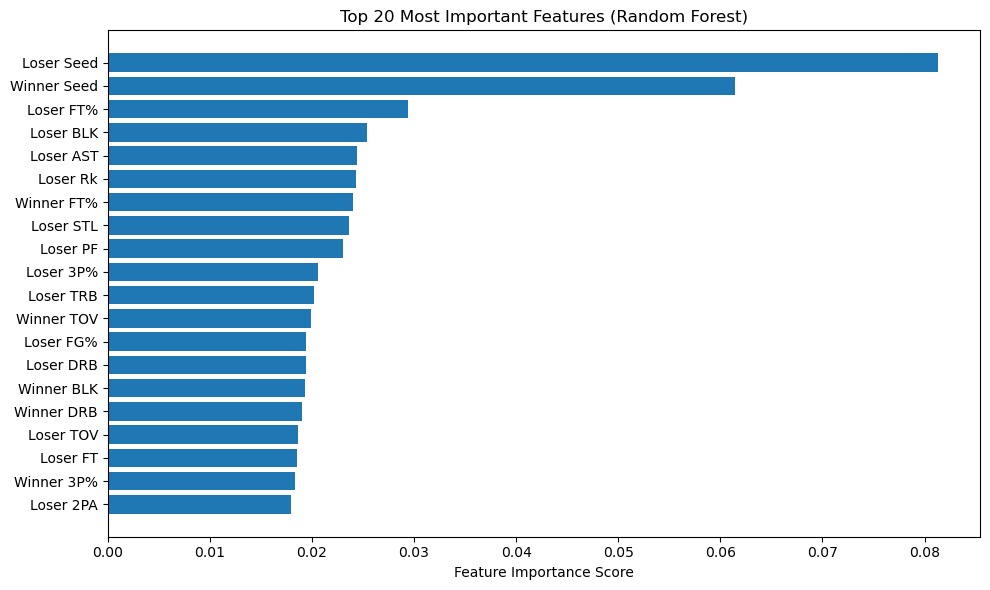

In [68]:
# Feature importance for Random Forest
feature_names = X_train.columns
rf_importances = rf_model.feature_importances_
sorted_idx = np.argsort(rf_importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

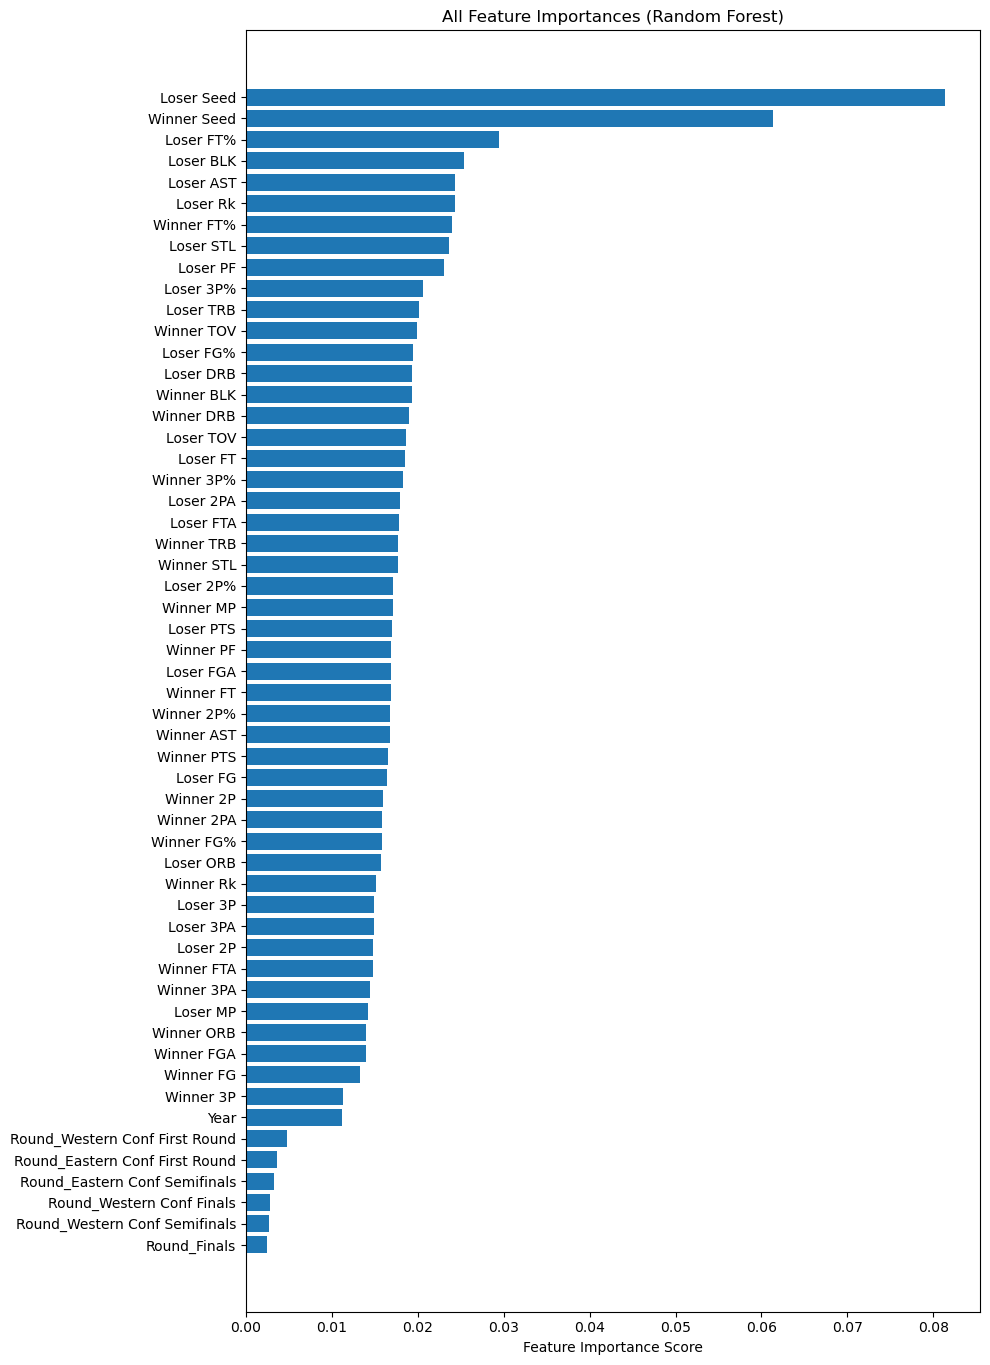

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Get all feature importances
feature_names = X_train.columns
rf_importances = rf_model.feature_importances_

# Sort all indices by importance
sorted_idx = np.argsort(rf_importances)

plt.figure(figsize=(10, len(feature_names) * 0.25))  # dynamically scale height
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('All Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [112]:
rf_final_preds = rf_model.predict(data2025)

results = pd.DataFrame({
    'Match': match,
    'Predictions': rf_final_preds
})

print(results)

                                           Match  Predictions
0              Indiana Pacers VS Milwaukee Bucks            3
1             New York Knicks VS Detroit Pistons            4
2                Boston Celtics VS Orlando Magic            3
3              Cleveland Cavaliers VS Miami Heat            3
4    Oklahoma City Thunder VS Memphis Grizzlies             3
5         Denver Nuggets VS Los Angeles Clippers            3
6  Los Angeles Lakers VS Minnesota Timberwolves             2
7      Golden State Warriors VS Houston Rockets             3
